# Capstone Project - Sentimental Analysis on the Singapore Stock Market

### Library

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import keras
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
import importlib
import pickle

/var/folders/tg/k93_32z969551218v1lzn_4w0000gn/T/ipykernel_9125/3138673216.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yvonnepeh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2024-02-12 22:38:55.360279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import functions as fn, sentiment_analysis as sa, model

### Import and Data 

In [4]:
'''
Stocks are downloaded from yahoo finance from Jan 2015 to Dec 2022 for analysis 
which are in line with the period of the sentiment analysis available (later part)
The function returns the merged data and the invidual stocks. 
'''
data, es3, amzn, msft, aapl, tsla, goog = fn.read_process_stock()

In [5]:
data.head(2)

,Date,Open_amzn,High_amzn,Low_amzn,Close_amzn,Adj Close_amzn,Volume_amzn,Open_msft,High_msft,Low_msft,Close_msft,Adj Close_msft,Volume_msft,Open_aapl,High_aapl,Low_aapl,Close_aapl,Adj Close_aapl,Volume_aapl,Open_tsla,High_tsla,Low_tsla,Close_tsla,Adj Close_tsla,Volume_tsla,Open_goog,High_goog,Low_goog,Close_goog,Adj Close_goog,Volume_goog,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3
0,2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000,46.660000,47.419998,46.540001,46.759998,40.452747,27913900,27.8475,27.860001,26.837500,27.3325,24.466450,212818400,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,26.378078,26.49077,26.133251,26.168653,26.168653,28951268,3.40,3.42,3.40,3.41,2.512212,114000.0
1,2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000,46.369999,46.730000,46.250000,46.330002,40.080730,39673900,27.0725,27.162500,26.352501,26.5625,23.777189,257142000,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,26.091366,26.14472,25.582764,25.623152,25.623152,41196796,3.41,3.41,3.36,3.37,2.482742,165000.0


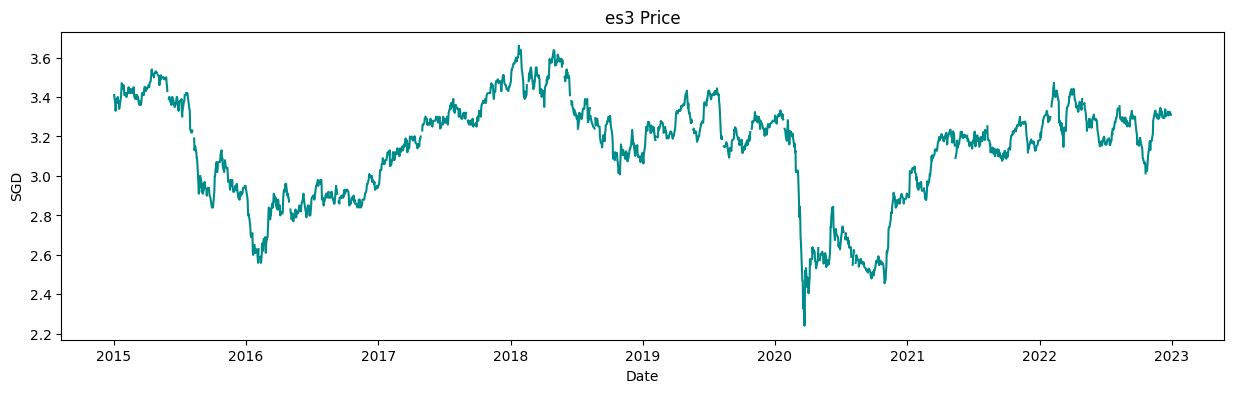

In [6]:
fn.plot_ts(data, 'es3', 'SGD')

In [7]:
data_1617 = fn.data_2016_2017(data) #obtain 2016 and 2017 data for train-test

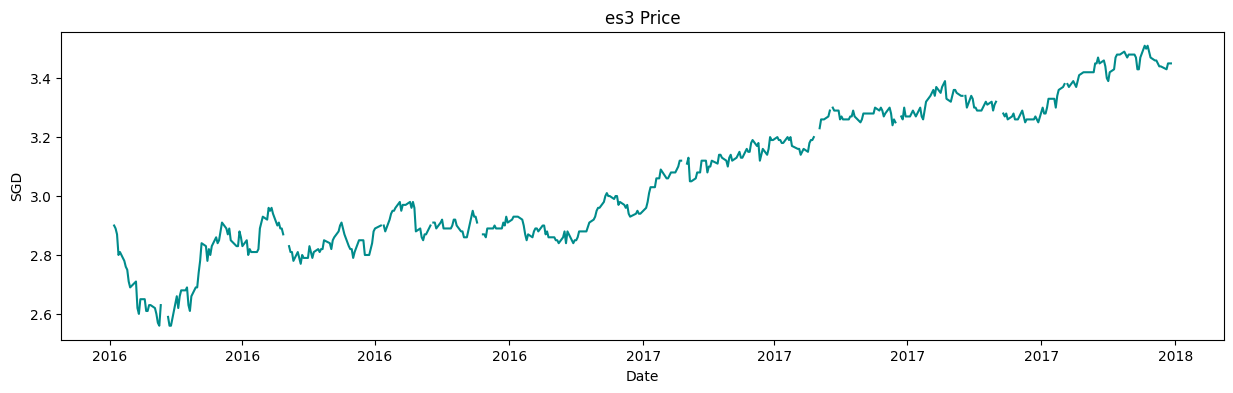

In [8]:
fn.plot_ts(data_1617, 'es3', 'SGD')

,Close_amzn,Close_msft,Close_aapl,Close_tsla,Close_goog,Close_es3
Close_amzn,1.000000,0.941533,0.926622,0.806732,0.947235,0.945309
Close_msft,0.941533,1.000000,0.967656,0.819955,0.977545,0.946874
Close_aapl,0.926622,0.967656,1.000000,0.878794,0.966207,0.959121
Close_tsla,0.806732,0.819955,0.878794,1.000000,0.862280,0.888804
Close_goog,0.947235,0.977545,0.966207,0.862280,1.000000,0.947545
Close_es3,0.945309,0.946874,0.959121,0.888804,0.947545,1.000000


<Axes: >

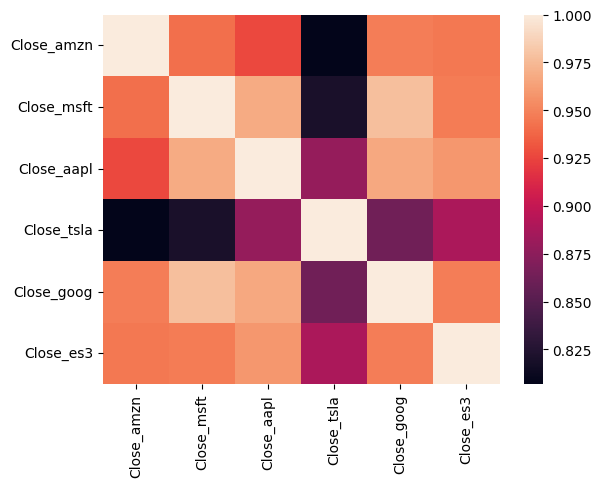

In [9]:
# get correlation between close price of the US stocks and es3 
fn.get_corr(data_1617)

From the correlation graphics, we can see that the top 3 with highest correlation to es3 are msft, goog and aapl which we will be using sentiment analysis for. The following are plots of the stocks which all demonstrate similar trends during this period of time. 

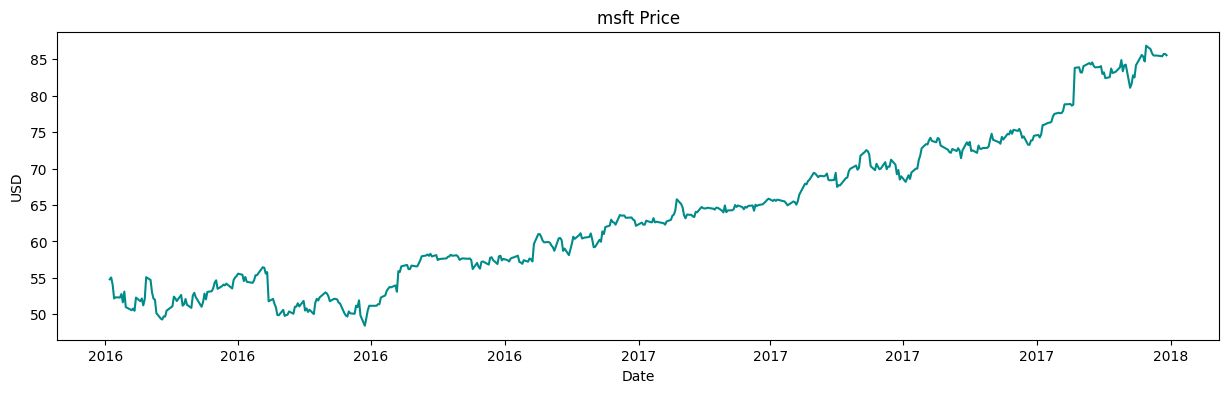

In [10]:
fn.plot_ts(data_1617, 'msft', 'USD')

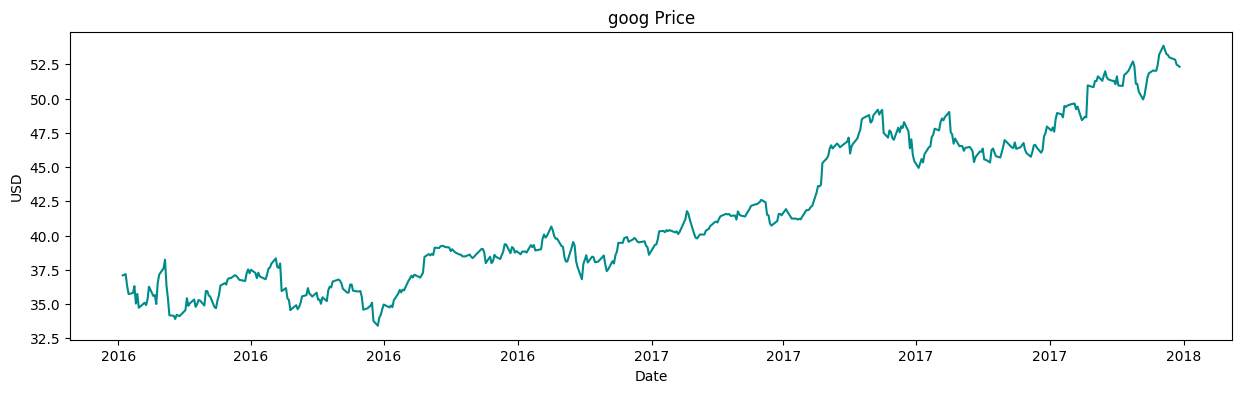

In [11]:
fn.plot_ts(data_1617, 'goog', 'USD')

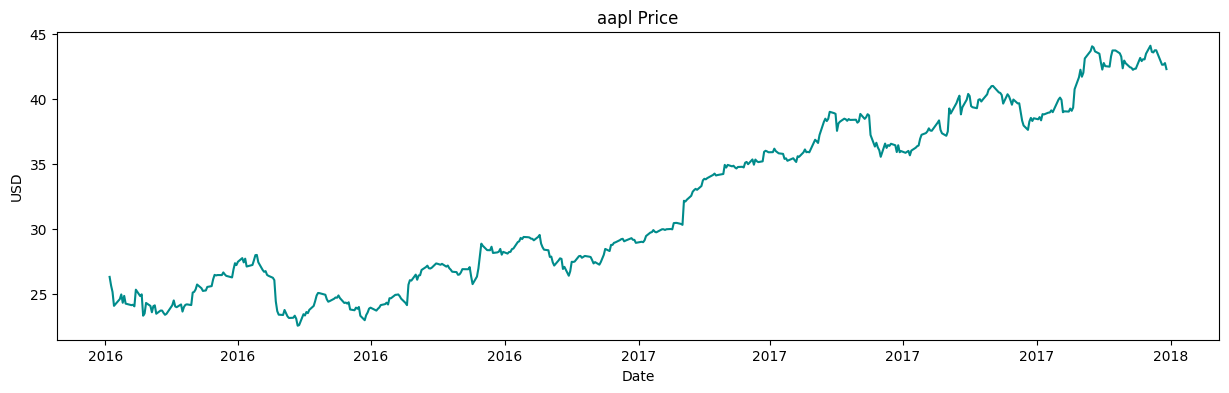

In [12]:
fn.plot_ts(data_1617, 'aapl', 'USD')

## Prepare ES3 stock-related features

In order to help the model understand the trend of the training data better and give better predictions, technical indicators listed in the following are added. 
- Moving averages (MA7 and MA20)
- Bollinger bands (lower and upper)
- MACD: subtracting the 26-period exponential moving average (EMA) from the 12-period EMA

,Date,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,20SD,upper_band,lower_band
228,2016-01-04,2.95,2.95,2.88,2.90,2.198987,665800,2.935714,2.9195,-0.001563,0.023946,2.967392,2.871608
229,2016-01-05,2.90,2.90,2.88,2.89,2.191404,511700,2.931429,2.9175,0.000643,0.024682,2.966864,2.868136


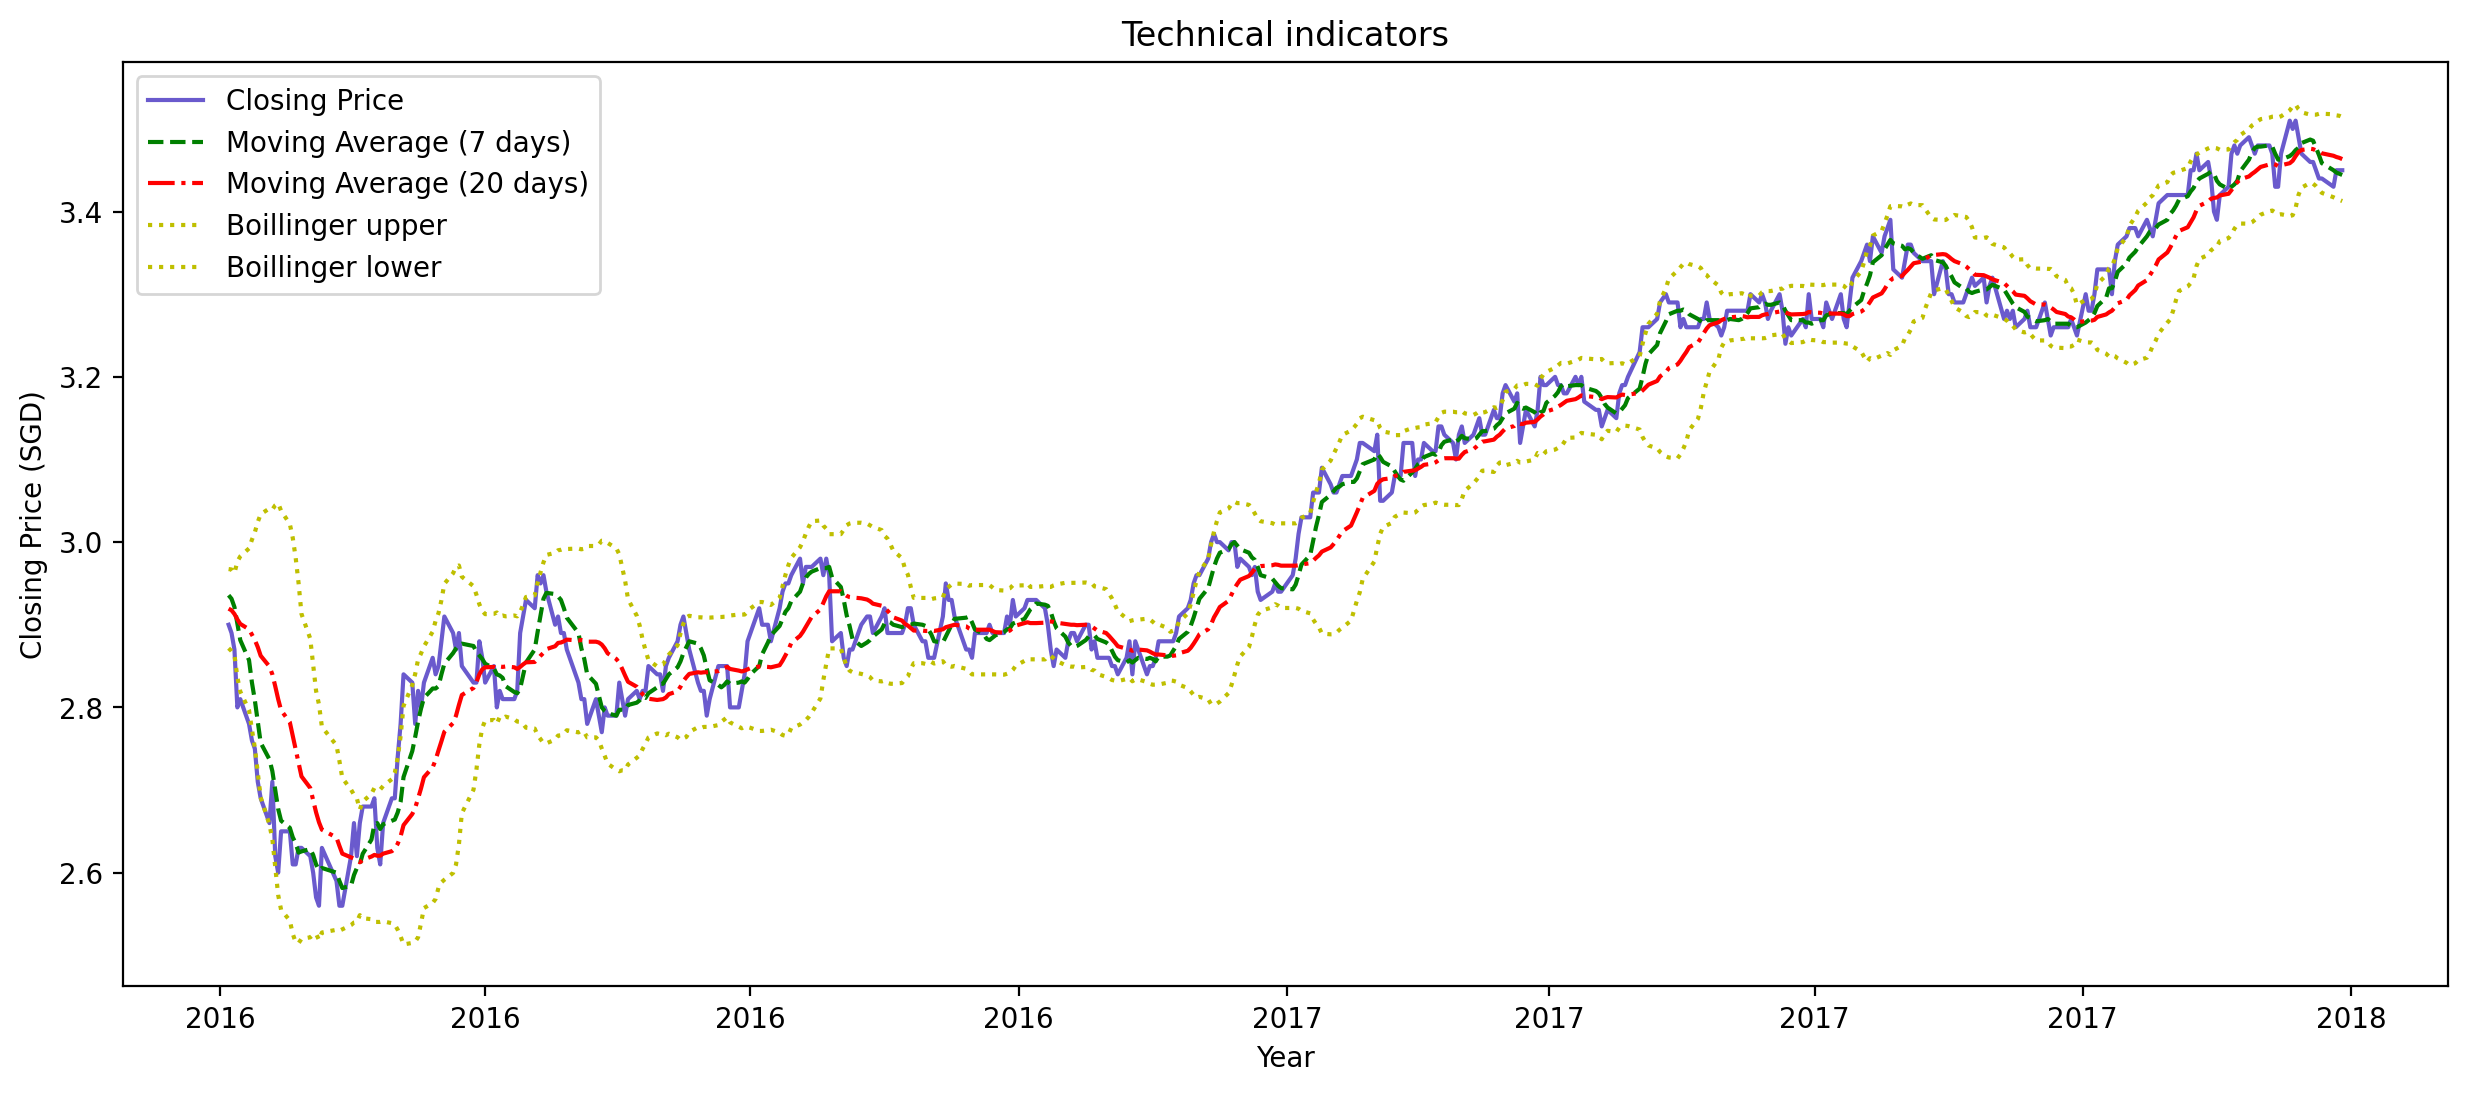

In [13]:
es3ta_1617 = fn.prep_es3_with_technical_analysis(es3)

## Prepare Sentiment Analysis (SA)

Dataset: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020/data

In [16]:
tweet_old = pd.read_csv('Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')
coy_tweet = pd.read_csv('Company_Tweet.csv',engine='python',encoding='utf-8',on_bad_lines='warn')

In [17]:
tweets = sa.process_sa_data(tweet_old, coy_tweet)

There are 3717964 tweet in total.
Data Read: 


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0


,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL


From 2016 to 2017, there are 1678172 tweets.


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,date,ticker_symbol
0,682712868064747520,amigobulls,1451606406,10 Reasons why $AAPL is underpriced - part 2 h...,0,0,0,2016-01-01,AAPL
1,682712975996661760,Maximum_Pain_cm,1451606432,$AMZN Max Pain = 680.00. Maturity = 12/31/2015...,0,0,0,2016-01-01,AMZN


In [18]:
tweets.body[100]

'#Nasdaq Outperforms: 3 #ETFs in Focus $ONEQ $QQEW $QQQ Also $IBB $AAPL $AMZN $MSFT $XLE $GOOGL http://goo.gl/Mgx00z'

In [19]:
sia = SentimentIntensityAnalyzer()

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
print(sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now'))

Tesla misses quarterly earnings, analyst calls downgrade, sell now
{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'compound': -0.2263}


In [20]:
print('Google earnings is not looking that bad, analyst recommends hold')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends hold')

Google earnings is not looking that bad, analyst recommends hold


{'neg': 0.0, 'neu': 0.627, 'pos': 0.373, 'compound': 0.5789}

### Augment Vocabulary for Stocks to Improve SA
We can improve the sentiment analysis scores by augmenting vocabulary meant for stock purpose. \
Example is telling VADER that positive words include 'underpriced, bullish, high profit etc.'.

In [21]:
positive_words='high profit Growth Potential Opportunity Bullish Strong Valuable Success \
Promising Profitable Win Winner Outstanding Record Earnings Breakthrough buy bull long \
support undervalued underpriced cheap upward rising trend moon rocket hold breakout call \
beat support buying holding'
negative_words='resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining \
Uncertain Troubling Downturn Struggle Unstable Volatile Slump Disaster Plunge sell bear \
bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss'

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)

print('Tesla misses quarterly earnings, analyst calls downgrade, sell now')
sia.polarity_scores('Tesla misses quarterly earnings, analyst calls downgrade, sell now')

Tesla misses quarterly earnings, analyst calls downgrade, sell now


{'neg': 0.496, 'neu': 0.504, 'pos': 0.0, 'compound': -0.7845}

In [22]:
print('Google earnings is not looking that bad, analyst recommends hold')
sia.polarity_scores('Google earnings is not looking that bad, analyst recommends hold')

Google earnings is not looking that bad, analyst recommends hold


{'neg': 0.0, 'neu': 0.418, 'pos': 0.582, 'compound': 0.8674}

In [23]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'MSFT', 'GOOG', 'GOOGL', 'TSLA'], dtype=object)

In [24]:
tweets['ticker_symbol'] = np.where(tweets['ticker_symbol'] =='GOOGL', 'GOOG', tweets['ticker_symbol'])

In [25]:
tweets.ticker_symbol.unique()

array(['AAPL', 'AMZN', 'MSFT', 'GOOG', 'TSLA'], dtype=object)

In [ ]:
s_aapl = sa.get_sentiment(sia, tweets,'AAPL',start='2016-01-01',end='2017-12-31')
s_msft = sa.get_sentiment(sia, tweets,'MSFT',start='2016-01-01',end='2017-12-31')
s_goog = sa.get_sentiment(sia, tweets,'GOOG',start='2016-01-01',end='2017-12-31')

In [37]:
s_goog.head(2)

,date,score,label,tweet_id,body
3,2016-01-01,0.25,neutral,682713776584396801,Netflix: 2016 Outlook - Slight Chance Of Showe...
4,2016-01-01,0.25,neutral,682713776584396801,Netflix: 2016 Outlook - Slight Chance Of Showe...


In [49]:
#process the sentiment analysis scores of all 3 stocks and merge with es3 2016 2017 dataset. Also drop 20SD. 
final = sa.get_es3_sa([s_aapl, s_msft, s_goog], 
                      ['aapl_avg_score','msft_avg_score','goog_avg_score'], es3ta_1617) 

,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,upper_band,lower_band,goog_avg_score
2016-01-04,2.95,2.95,2.88,2.90,2.198987,665800,2.935714,2.9195,-0.001563,2.967392,2.871608,0.087948
2016-01-05,2.90,2.90,2.88,2.89,2.191404,511700,2.931429,2.9175,0.000643,2.966864,2.868136,0.058207
2016-01-06,2.89,2.90,2.87,2.87,2.176239,516500,2.921429,2.9130,0.002307,2.962460,2.863540,0.076407
2016-01-07,2.87,2.87,2.80,2.80,2.123160,2925100,2.901429,2.9065,0.001248,2.976470,2.836530,0.058930
2016-01-08,2.80,2.82,2.77,2.81,2.130742,1294000,2.881429,2.9010,0.011117,2.982796,2.819204,0.116196


In [50]:
final[final.isnull().any(axis=1)]

,Open_es3,High_es3,Low_es3,Close_es3,Adj Close_es3,Volume_es3,MA7,MA20,MACD,upper_band,lower_band,goog_avg_score


In [ ]:
final.to_pickle('final.pkl')

## Build Model

In [ ]:
%cd data
final = pd.read_pickle('final.pkl')
learning_rate = 5e-4
epochs = 200 

### MODEL WITH SENTIMENT ANALYSIS

- Create directory for each experiment before TRAIN MODEL
- Restart Kernel and Load Library, run Build Model Section before train specific model

#### Compare batch size and impact 

In [8]:
print('Testing Data Points: ', np.round(len(final)*0.2))

Testing Data Points:  100.0


X shape: (499, 3, 12)
y shape: (499, 1)
yc shape: (499, 3, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [00:43<01:29,  1.68it/s]

epoch 50 discriminator_loss 1.3348594 generator_loss 0.7353494


 50%|████████████████████▌                    | 100/200 [01:11<00:58,  1.72it/s]

epoch 100 discriminator_loss 1.3888249 generator_loss 0.6948902


 75%|██████████████████████████████▊          | 150/200 [01:38<00:28,  1.73it/s]

epoch 150 discriminator_loss 1.3857534 generator_loss 0.6921517


100%|█████████████████████████████████████████| 200/200 [02:06<00:00,  1.59it/s]

epoch 200 discriminator_loss 1.3776104 generator_loss 0.6991882


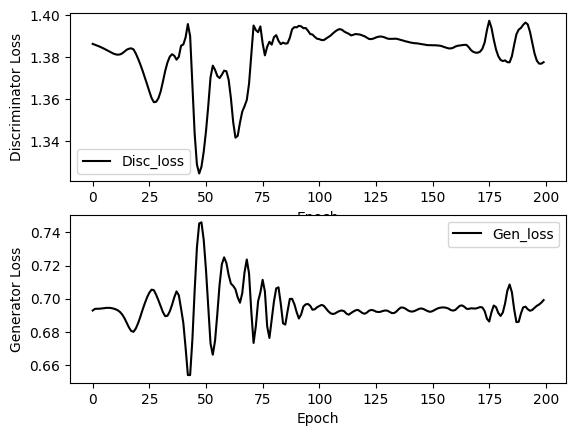

train RMSE:  0.055088683793853
train MAPE:  0.014964267324631806


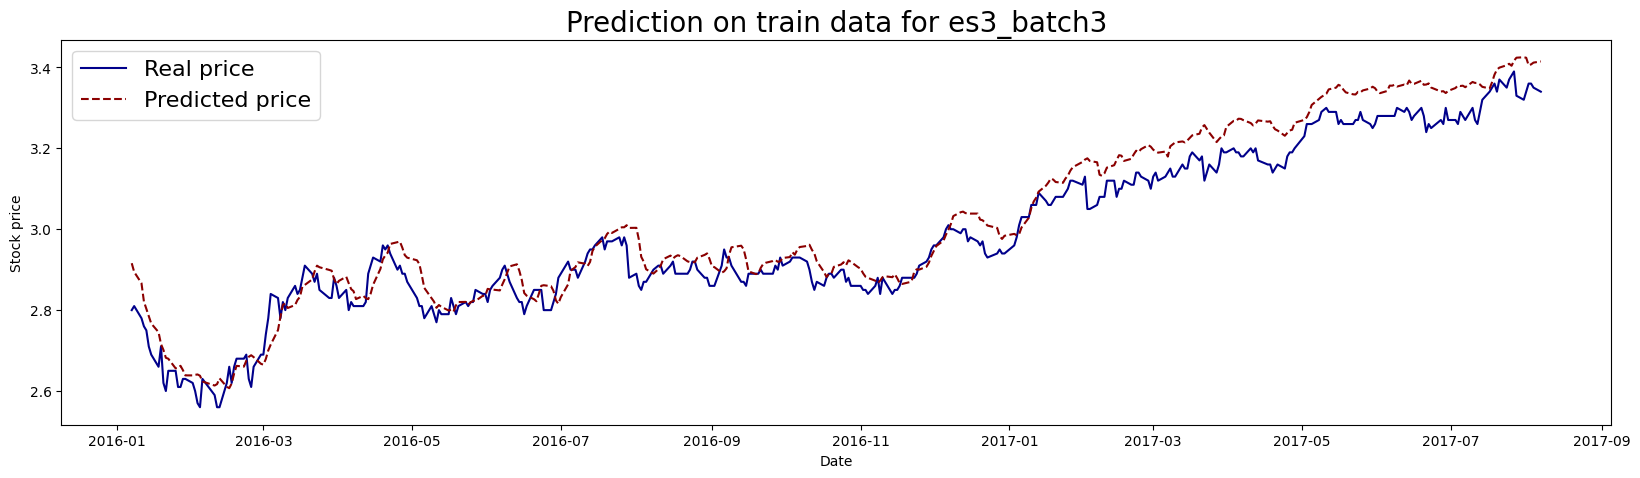

test RMSE:  0.051079466595252365
test MAPE:  0.012402185126320122


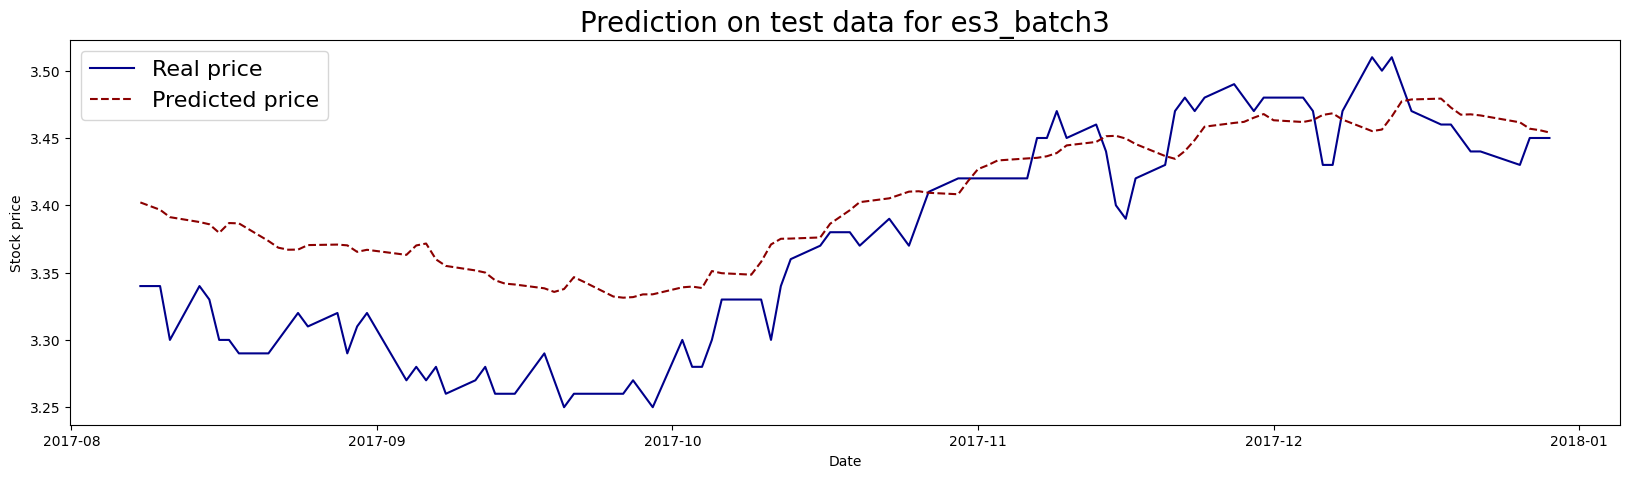

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [9]:
model.prep_data_run_model('es3_batch3', final, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=1)

X shape: (497, 5, 12)
y shape: (497, 1)
yc shape: (497, 5, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:02<02:18,  1.08it/s]

epoch 50 discriminator_loss 1.3798082 generator_loss 0.69489074


 50%|████████████████████▌                    | 100/200 [01:49<01:33,  1.08it/s]

epoch 100 discriminator_loss 1.3867517 generator_loss 0.6924442


 75%|██████████████████████████████▊          | 150/200 [02:34<00:48,  1.04it/s]

epoch 150 discriminator_loss 1.389617 generator_loss 0.69738084


100%|█████████████████████████████████████████| 200/200 [03:18<00:00,  1.01it/s]

epoch 200 discriminator_loss 1.386738 generator_loss 0.6916764


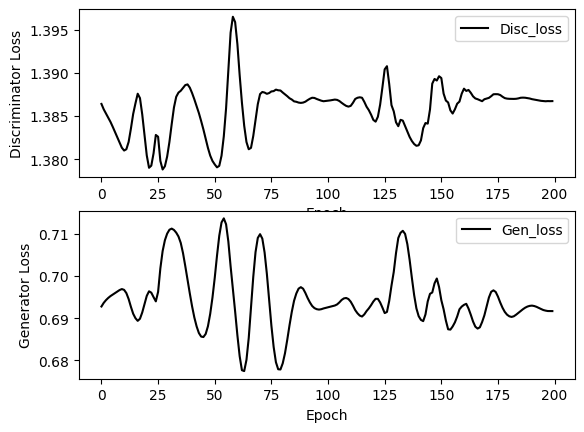

train RMSE:  0.039936764499353405
train MAPE:  0.010640154827623668


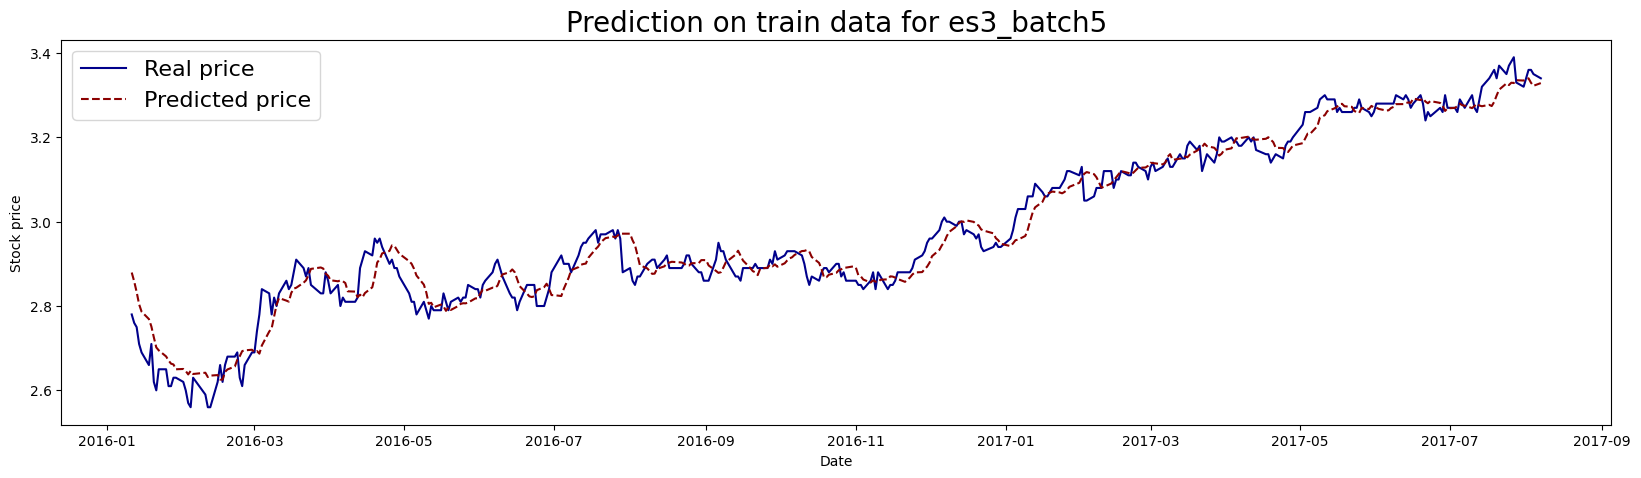

test RMSE:  0.04923151658141517
test MAPE:  0.011986110397797884


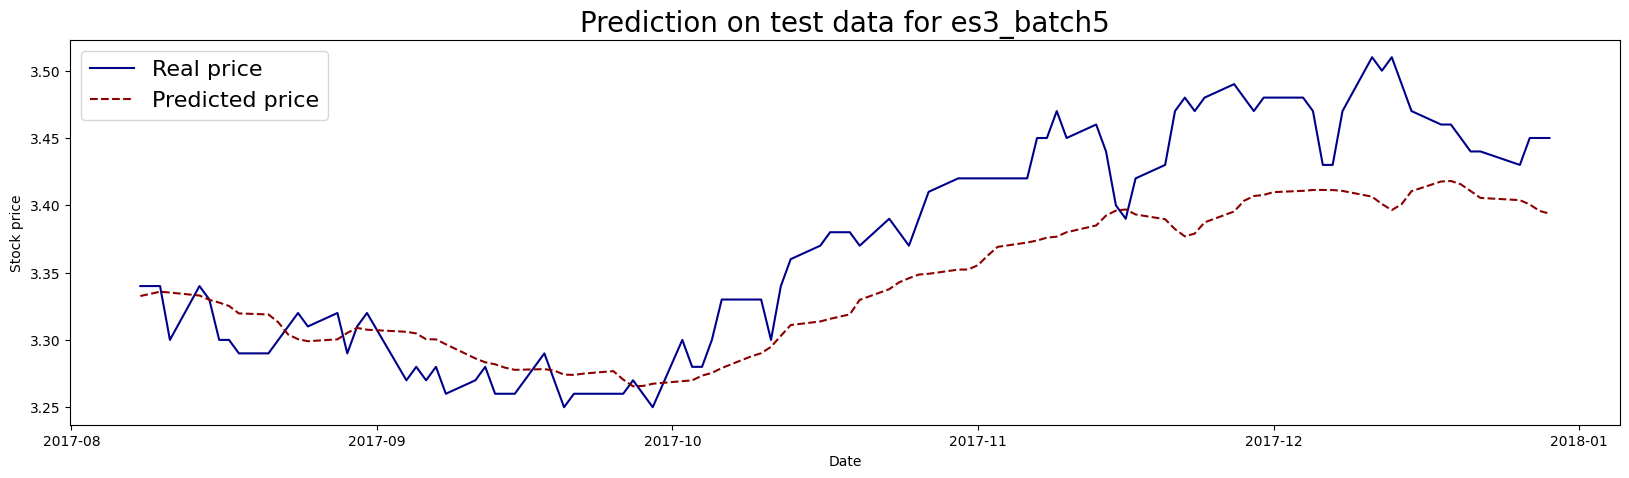

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [9]:
model.prep_data_run_model('es3_batch5', final, learning_rate, epochs, batch_size=5, predict_period=1, SA_indicator=1)

X shape: (495, 7, 12)
y shape: (495, 1)
yc shape: (495, 7, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:17<03:24,  1.36s/it]

epoch 50 discriminator_loss 1.3871979 generator_loss 0.69441646


 50%|████████████████████▌                    | 100/200 [02:18<02:01,  1.22s/it]

epoch 100 discriminator_loss 1.3862702 generator_loss 0.692152


 75%|██████████████████████████████▊          | 150/200 [03:19<01:07,  1.35s/it]

epoch 150 discriminator_loss 1.3969761 generator_loss 0.6471588


100%|█████████████████████████████████████████| 200/200 [04:20<00:00,  1.30s/it]

epoch 200 discriminator_loss 1.3863736 generator_loss 0.6979871


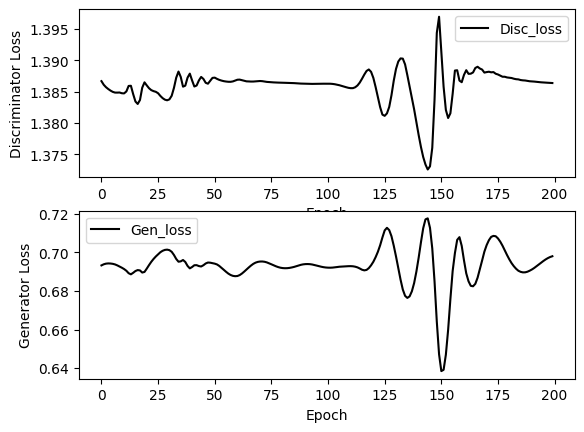

train RMSE:  0.048102454355345804
train MAPE:  0.012399240456120507


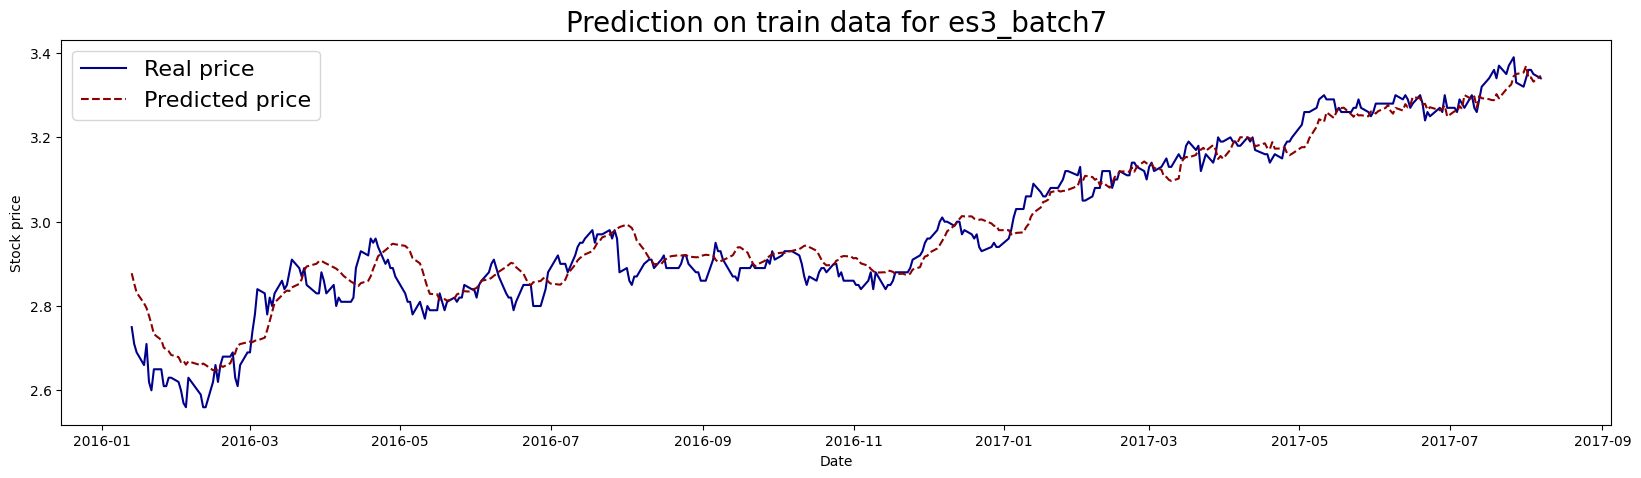

test RMSE:  0.036266472758077616
test MAPE:  0.009138128848797987


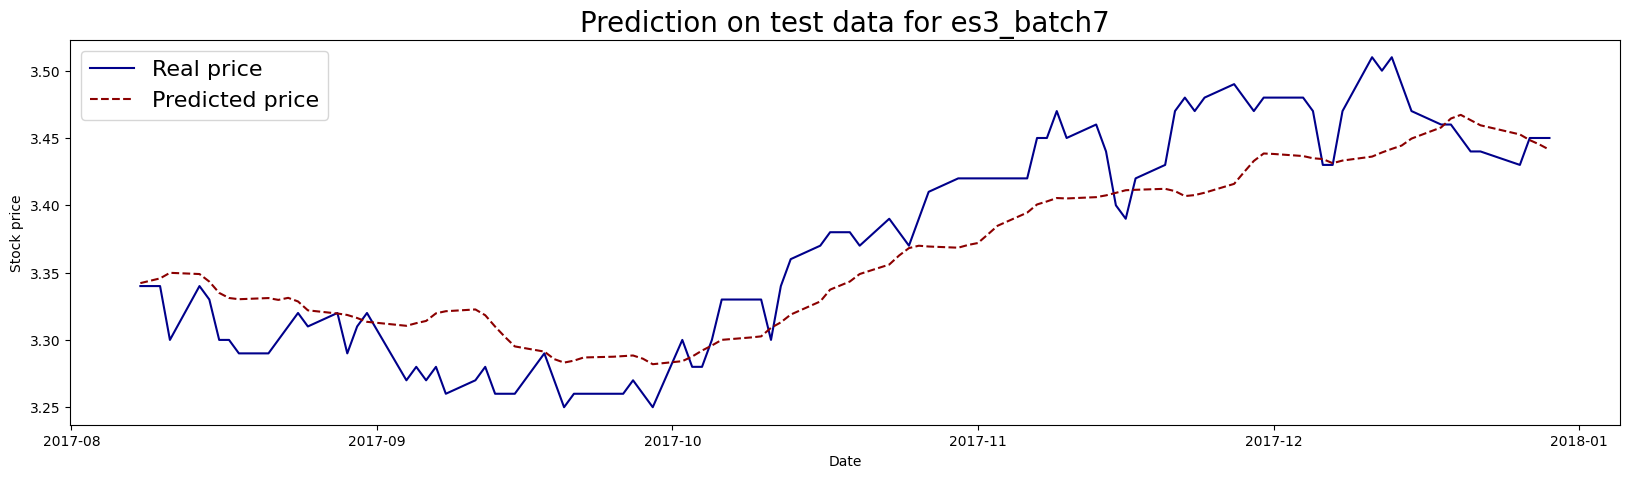

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [6]:
model.prep_data_run_model('es3_batch7', final, learning_rate,  epochs, batch_size=7, predict_period=1, SA_indicator=1)

### MODEL WITHOUT SENTIMENT ANALYSIS

X shape: (499, 3, 12)
y shape: (499, 1)
yc shape: (499, 3, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [00:46<01:28,  1.70it/s]

epoch 50 discriminator_loss 1.315145 generator_loss 0.7572213


 50%|████████████████████▌                    | 100/200 [01:12<00:57,  1.74it/s]

epoch 100 discriminator_loss 1.3957789 generator_loss 0.6993297


 75%|██████████████████████████████▊          | 150/200 [01:39<00:29,  1.72it/s]

epoch 150 discriminator_loss 1.3849083 generator_loss 0.6949758


100%|█████████████████████████████████████████| 200/200 [02:08<00:00,  1.56it/s]

epoch 200 discriminator_loss 1.3819492 generator_loss 0.69749683


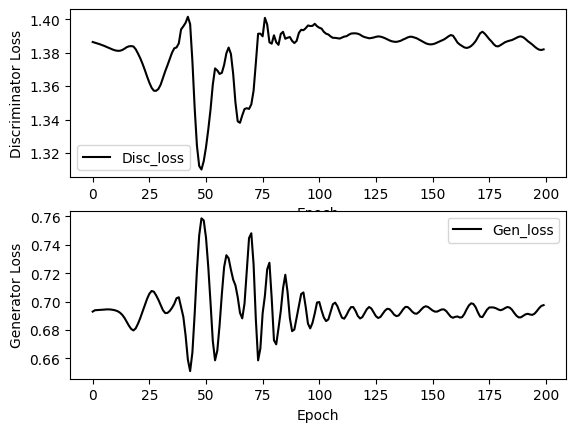

train RMSE:  0.041982976974755275
train MAPE:  0.011480915640703814


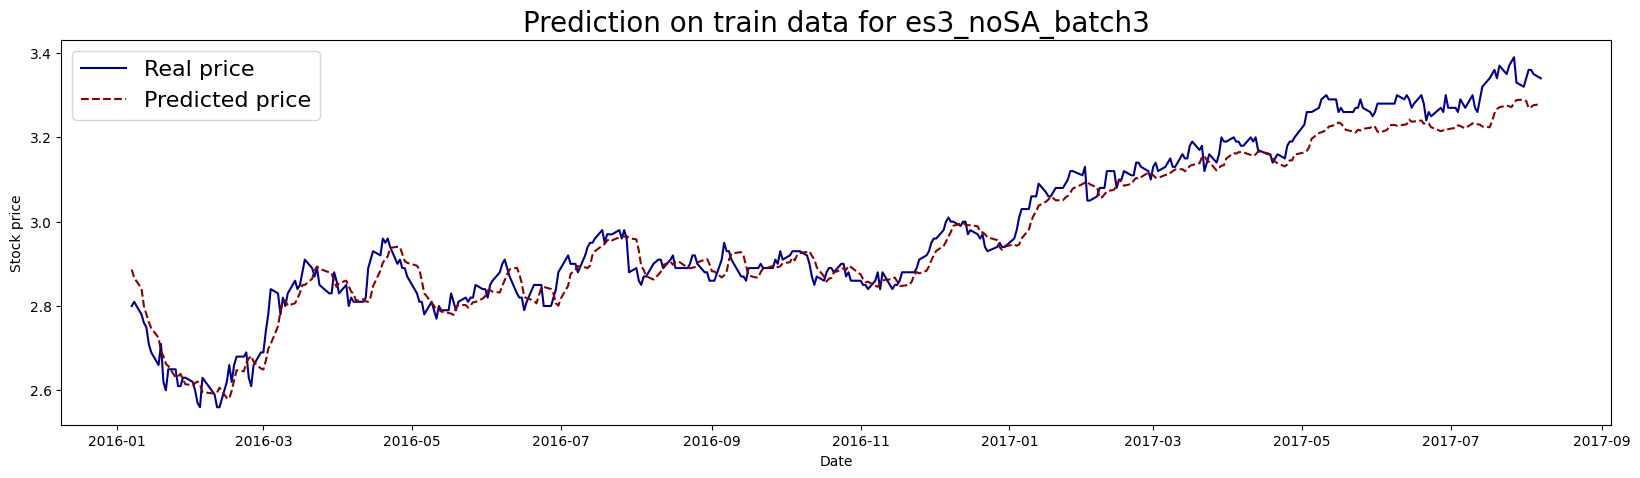

test RMSE:  0.08940478606978279
test MAPE:  0.024020671208198313


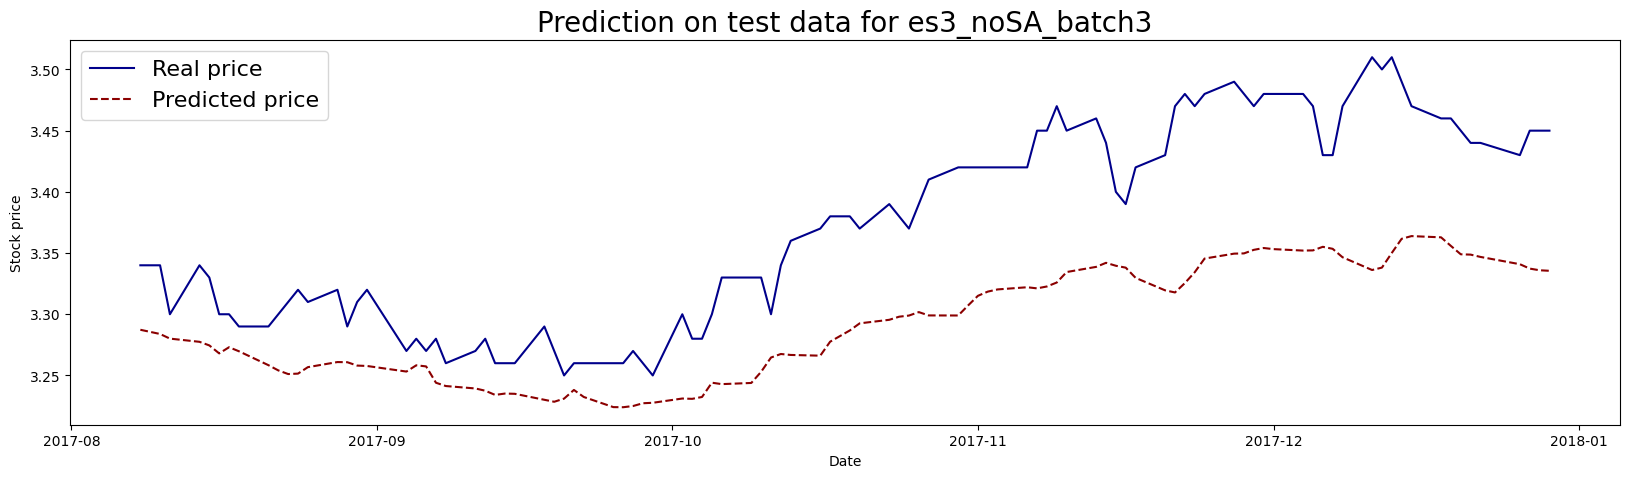

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('es3_noSA_batch3', final, learning_rate, epochs, batch_size=3, predict_period=1, SA_indicator=0)

X shape: (497, 5, 12)
y shape: (497, 1)
yc shape: (497, 5, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:02<02:30,  1.00s/it]

epoch 50 discriminator_loss 1.3801697 generator_loss 0.6906454


 50%|████████████████████▌                    | 100/200 [01:45<01:28,  1.12it/s]

epoch 100 discriminator_loss 1.3873947 generator_loss 0.69257176


 75%|██████████████████████████████▊          | 150/200 [02:28<00:47,  1.04it/s]

epoch 150 discriminator_loss 1.3863183 generator_loss 0.69428134


100%|█████████████████████████████████████████| 200/200 [03:12<00:00,  1.04it/s]

epoch 200 discriminator_loss 1.3862975 generator_loss 0.69347507


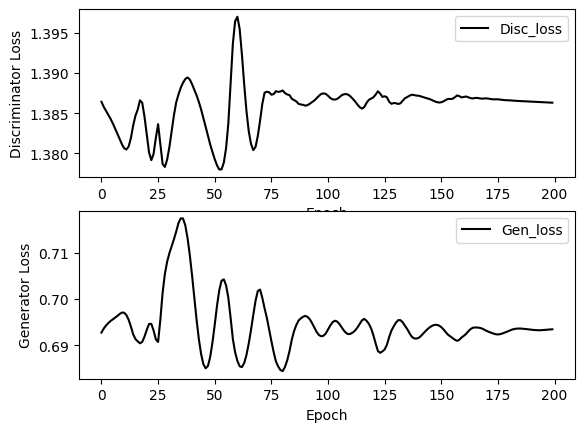

train RMSE:  0.04199148617587615
train MAPE:  0.011310839591387078


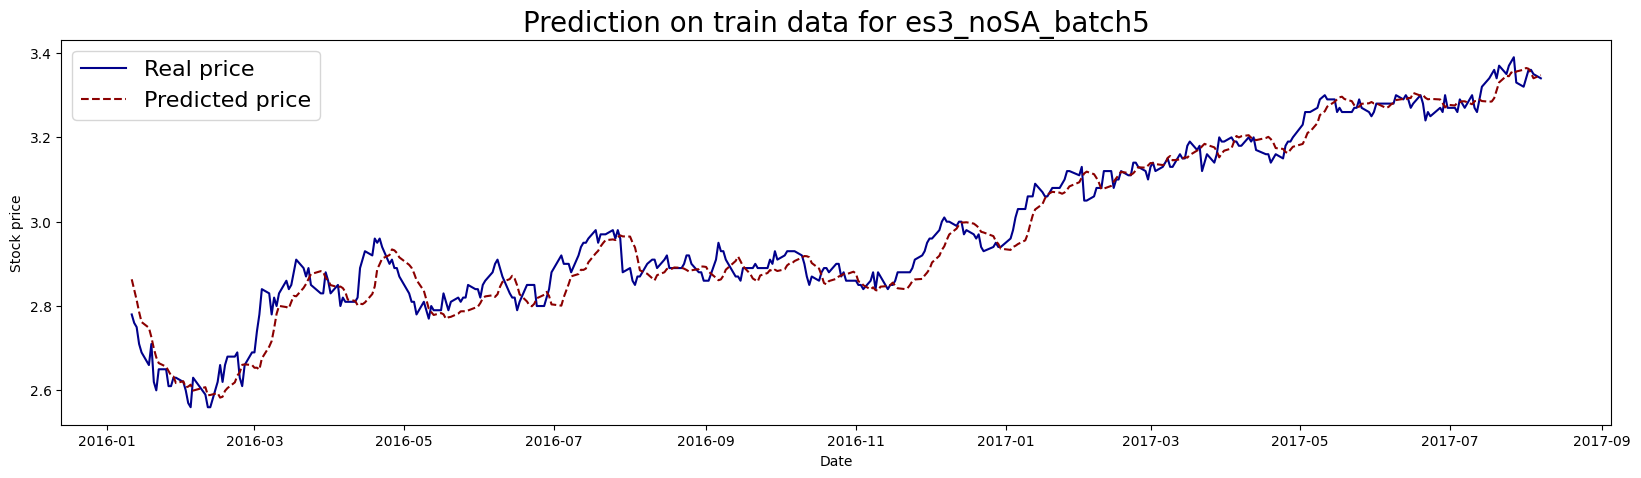

test RMSE:  0.032572023556382605
test MAPE:  0.008138751815399619


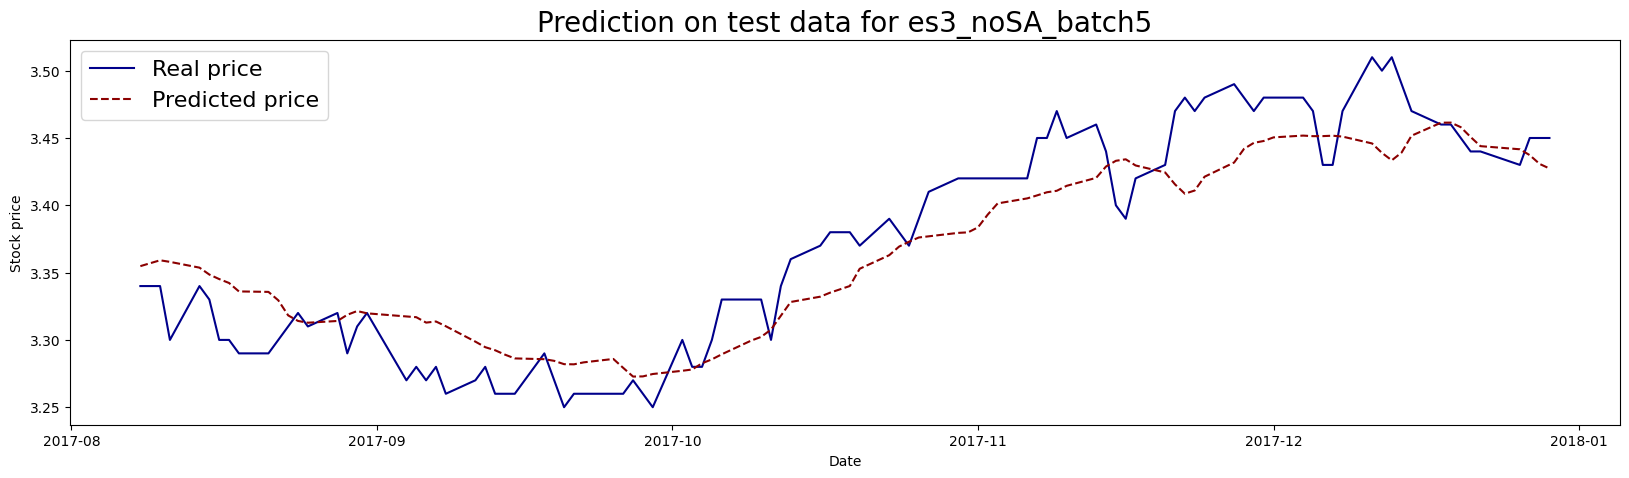

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('es3_noSA_batch5', final, learning_rate, epochs, batch_size=5, predict_period=1, SA_indicator=0)

X shape: (495, 7, 12)
y shape: (495, 1)
yc shape: (495, 7, 1)


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 25%|██████████▌                               | 50/200 [01:16<03:04,  1.23s/it]

epoch 50 discriminator_loss 1.3867495 generator_loss 0.69177634


 50%|████████████████████▌                    | 100/200 [02:17<02:07,  1.28s/it]

epoch 100 discriminator_loss 1.3867507 generator_loss 0.6939305


 75%|██████████████████████████████▊          | 150/200 [03:20<01:19,  1.58s/it]

epoch 150 discriminator_loss 1.3856857 generator_loss 0.7026801


100%|█████████████████████████████████████████| 200/200 [04:19<00:00,  1.30s/it]

epoch 200 discriminator_loss 1.3862133 generator_loss 0.69334406


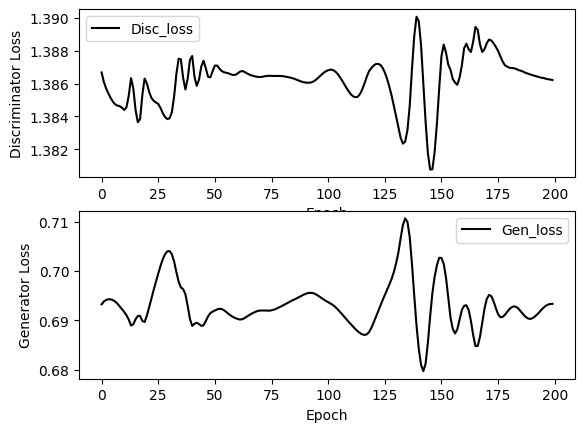

train RMSE:  0.055940077525713484
train MAPE:  0.014621030376487688


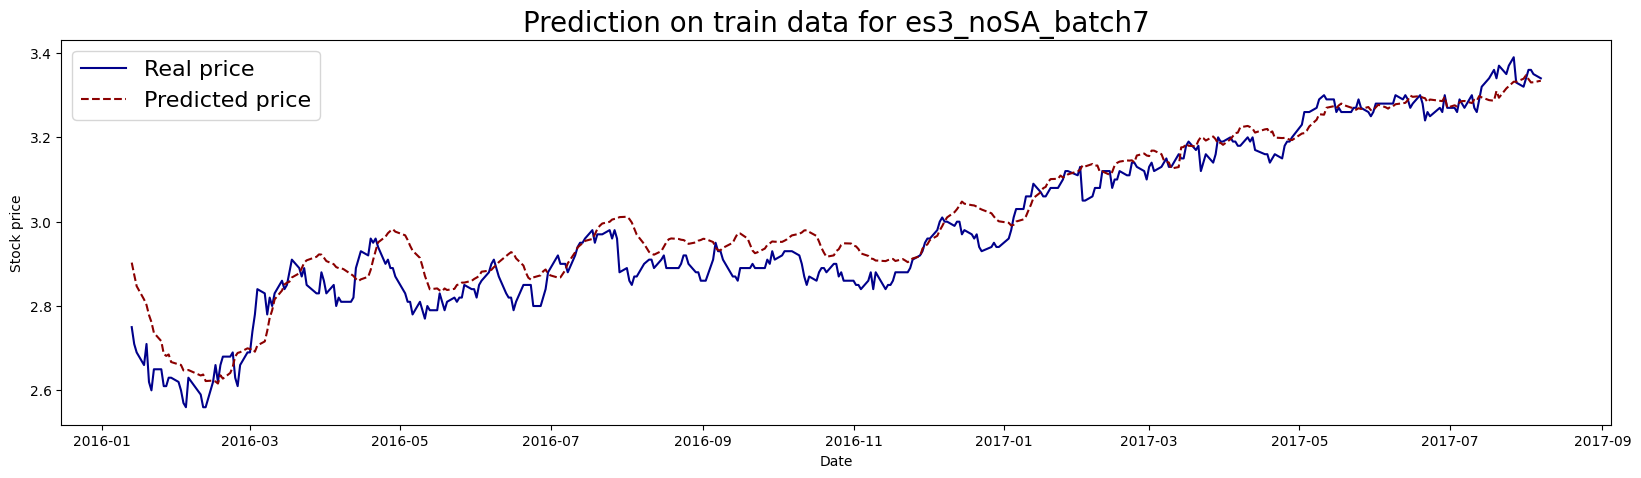

test RMSE:  0.05130399278917126
test MAPE:  0.012954482708374399


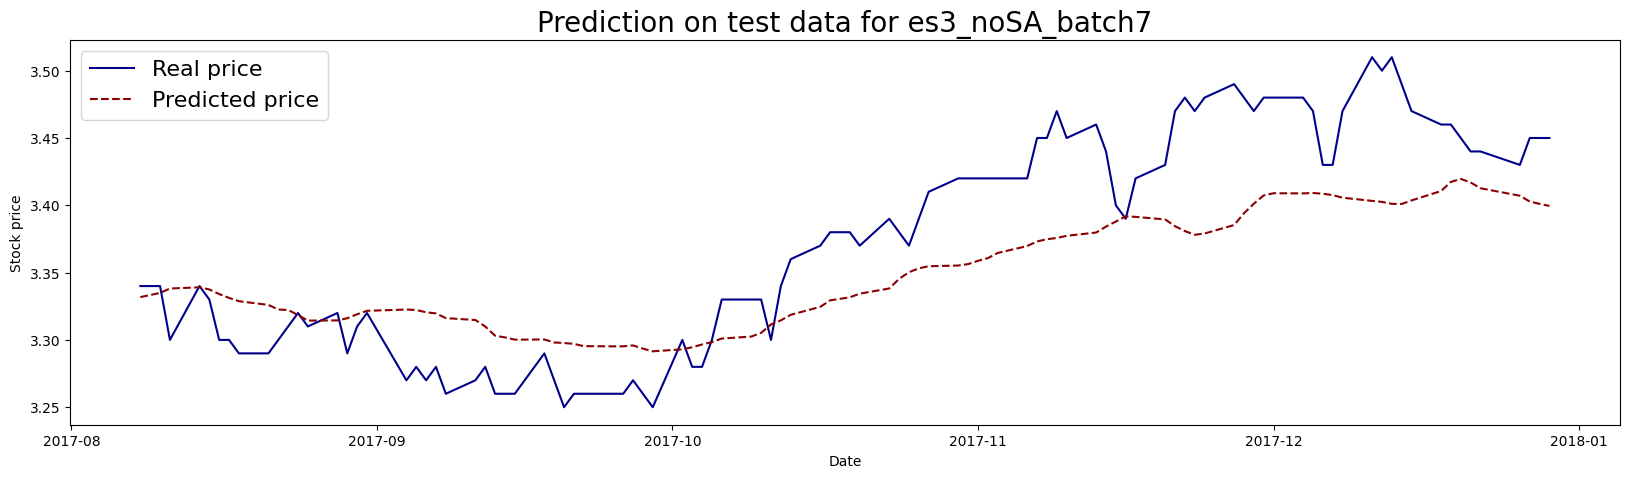

/Users/yvonnepeh/Downloads/proj/lib/python3.11/site-packages/numpy/lib/format.py:368: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [5]:
model.prep_data_run_model('es3_noSA_batch7', final, learning_rate, epochs, batch_size=7, predict_period=1, SA_indicator=0)

### TRADING STRATEGIES - Returns

Strategy daily rebalance Return: -4.97 %
Buy and Hold Return: 3.29 %


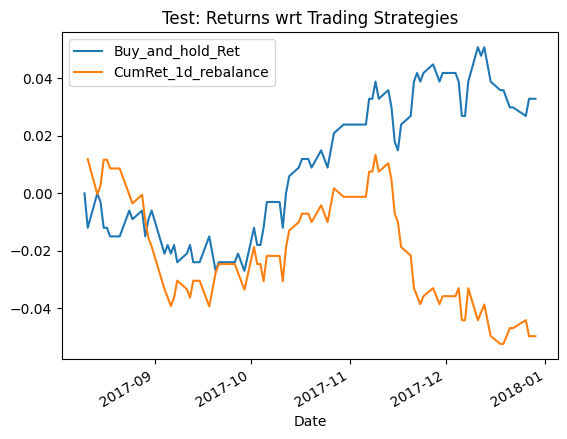

In [52]:
final_ret3, buy_ret3, returns3 = model.returns_strat('Test', batch_size=3, stock_name='es3_batch3')

Strategy daily rebalance Return: -2.02 %
Buy and Hold Return: 3.29 %


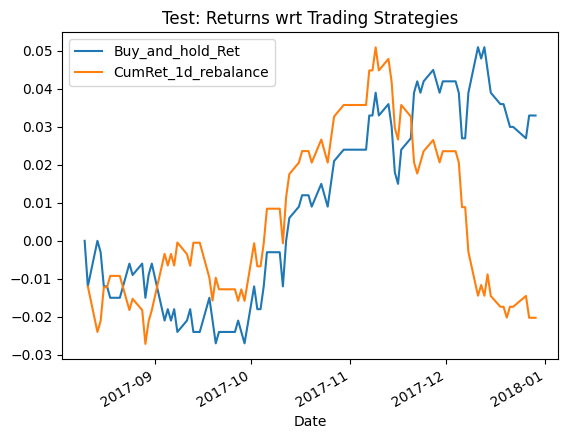

In [54]:
final_ret5, buy_ret5, returns5 = model.returns_strat('Test', batch_size=5, stock_name='es3_batch5')

Strategy daily rebalance Return: 5.72 %
Buy and Hold Return: 3.29 %


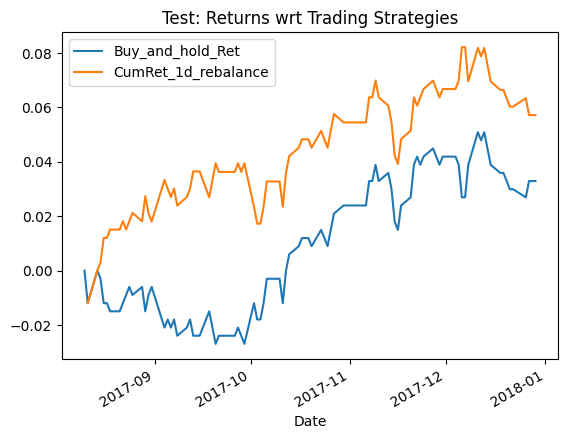

In [57]:
final_ret7, buy_ret7, returns7 = model.returns_strat('Test', batch_size=7, stock_name='es3_batch7')

Strategy daily rebalance Return: -4.31 %
Buy and Hold Return: 3.29 %


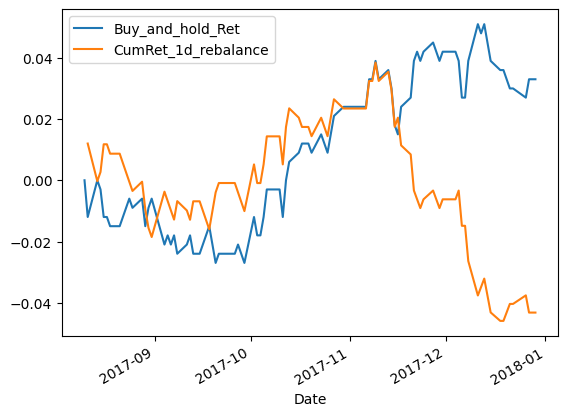

In [42]:
final_ret3_wo, buy_ret3_wo, returns3_wo = model.returns_strat(batch_size=3, stock_name='es3_noSA_batch3')

Strategy daily rebalance Return: 2.62 %
Buy and Hold Return: 3.29 %


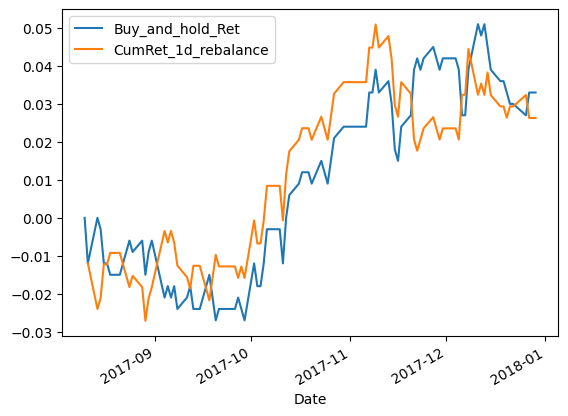

In [43]:
final_ret5_wo, buy_ret5_wo, returns5_wo = model.returns_strat(batch_size=5, stock_name='es3_noSA_batch5')

Strategy daily rebalance Return: -4.41 %
Buy and Hold Return: 3.29 %


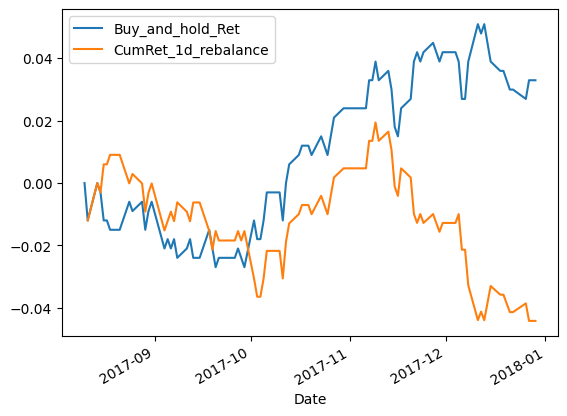

In [44]:
final_ret7_wo, buy_ret7_wo, returns7_wo = model.returns_strat(batch_size=7, stock_name='es3_noSA_batch7')